In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from keras.layers.convolutional import AveragePooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications.nasnet import NASNetLarge
# from keras.applications.densenet import DenseNet201
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import math

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

Using TensorFlow backend.


In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
log_dir = os.path.join(os.getcwd(), 'log_files')
result_dir = os.path.join(os.getcwd(), 'results')
model_name = 'kAP_res_01.h5'
log_file = 'KAP_res_01.csv'
result_file = 'AOI_res_01.csv'

# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
log_path = os.path.join(log_dir, log_file)
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
result_path = os.path.join(result_dir, result_file)

#data_path = '../at073-group37/F_P_bandboxed_1/'

In [0]:
from google.colab import files

uploaded = files.upload()

Saving img.tar to img.tar


In [2]:
!ls

img.tar  log_files  results  sample_data  saved_models	testset  train


In [0]:
!tar -xvf img.tar

testset/
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 101.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 102.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 103.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 104.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 105.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 106.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 107.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 108.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 109.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 110.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 111.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/20190605_04屬正常狀況 112.jpg
testset/20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)/2019

In [0]:
!ls

img.tar  log_files  results  sample_data  saved_models	testset  train


In [0]:
import cv2

['High', 'fireposition', 'roller', 'thick', 'normal']
001-(99).jpg


(480, 944, 3)

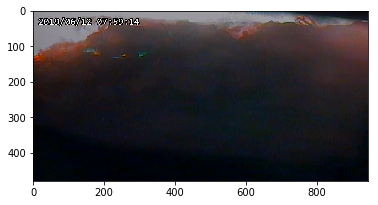

In [4]:
data_path = 'train'
# images 的路徑
file_list = os.listdir(data_path)
print(file_list)
class_path = os.path.join(data_path, file_list[3])
print(os.listdir(class_path)[0])
img = cv2.imread(os.path.join(class_path, os.listdir(class_path)[0]))[:,:,::-1]
#img = cv2.resize(img,(640,480))
plt.imshow(img)
img.shape

In [5]:
# test set 檔名list (*.jpg)
test_path = 'testset'
test_file = os.listdir(test_path)
print(len(test_file))
print(test_file[0])


5
20190613_19灰渣滾輪作動 (2019-6-20 上午 10-23-14)


In [0]:
def class_to_number(cl):
  dic = {'normal':0, 'roller':1,'thick':2, 'High':3, 'fireposition':4,\
         '20190605_04屬正常狀況 (2019-6-20 上午 10-23-13)':0,\
         '20190613_19灰渣滾輪作動 (2019-6-20 上午 10-23-14)':1,\
        '20190612_07層厚過厚 (2019-6-20 上午 10-23-14)':2,\
        '20190613_00灰渣段高度過高 (2019-6-20 上午 10-23-14)':3,\
        '20190611_23火焰位置分布不均 (2019-6-20 上午 10-23-13)':4}
  
  return dic.get(cl,None)

In [7]:
train_list = []
train_label = []
for i in range(5):
  class_path = os.path.join(data_path, file_list[i])
  file_list[i]
  for j in os.listdir(class_path):
    if j.endswith('.jpg'):
      train_list.append(os.path.join(class_path, j))
      train_label.append(class_to_number(file_list[i]))
train_label

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [8]:
test_list = []
test_label = []
for i in range(5):
  class_path = os.path.join(test_path, test_file[i])
  for j in os.listdir(class_path):
    if j.endswith('.jpg'):
      test_list.append(os.path.join(class_path, j))
      test_label.append(class_to_number(test_file[i]))
test_label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

(240, 480, 3)

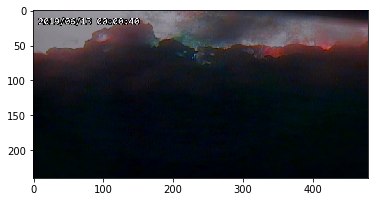

In [9]:
img = cv2.imread(train_list[10])[:,:,::-1]
img = cv2.resize(img,(480,240))
plt.imshow(img)
img.shape

In [10]:
print(len(train_list), len(train_label))
len(test_list), len(test_label)

500 500


(99, 99)

In [0]:
num_class = 5
y_true = np.eye(num_class)[train_label]
y_test = np.eye(num_class)[test_label]

In [12]:
print(y_true)
y_true.shape

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


(500, 5)

In [13]:
print(y_test)
y_test.shape

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0.

(99, 5)

In [0]:
img_x = 480
img_y = 240
img_channels = 3

In [0]:
from sklearn.model_selection import train_test_split
x_train_list, x_val_list, y_train, y_val = train_test_split(train_list, y_true, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (img_x,img_y),interpolation = cv2.INTER_AREA)

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape), 
            testing_shape=(len(x_val_list), img.shape)))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_val.shape))


input_data shape: training (450, (240, 480, 3)) ; testing (50, (240, 480, 3))
y_true shape: training (450, 5) ; testing (50, 5)


In [0]:
x_val_list

['train/roller/001-(18).jpg',
 'train/thick/001-(29).jpg',
 'train/roller/001-(10).jpg',
 'train/fireposition/001-(64).jpg',
 'train/High/001-(44).jpg',
 'train/roller/001-(95).jpg',
 'train/High/001-(83).jpg',
 'train/fireposition/001-(47).jpg',
 'train/fireposition/001-(66).jpg',
 'train/High/001-(88).jpg',
 'train/roller/001-(57).jpg',
 'train/normal/001-(49).jpg',
 'train/thick/001-(14).jpg',
 'train/fireposition/001-(27).jpg',
 'train/normal/001-(43).jpg',
 'train/fireposition/001-(92).jpg',
 'train/roller/001-(99).jpg',
 'train/normal/001-(59).jpg',
 'train/fireposition/001-(23).jpg',
 'train/High/001-(10).jpg',
 'train/thick/001-(39).jpg',
 'train/normal/001-(87).jpg',
 'train/thick/001-(79).jpg',
 'train/normal/001-(84).jpg',
 'train/High/001-(99).jpg',
 'train/thick/001-(58).jpg',
 'train/High/001-(69).jpg',
 'train/roller/001-(1).jpg',
 'train/High/001-(17).jpg',
 'train/fireposition/001-(46).jpg',
 'train/fireposition/001-(29).jpg',
 'train/High/001-(80).jpg',
 'train/roller

In [0]:
#print(train_path)
# validation data preprocessing



In [0]:
img_channels = 3

# base_model = ResNet50(include_top=False, weights='Pretrain/' + weight_file,
#                       input_shape=(img_x, img_y, img_channels))
# base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(img_x, img_y, img_channels))
# base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(img_x, img_y, img_channels)) 
#base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(img_x, img_y, img_channels))
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(img_y, img_x, img_channels))

#接上自訂輸出
X = base_model.output
# X = AveragePooling2D((2,2))(X)
X = GlobalAveragePooling2D()(X)
# X= Flatten()(X)
X = Dense(1024, activation='relu')(X)
predictions = Dense(num_class, activation='softmax')(X)
model = Model(inputs=base_model.input, outputs=predictions)
    
print(model.summary())

W0702 00:54:07.924718 140701231667072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 00:54:07.980408 140701231667072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 00:54:08.012821 140701231667072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0702 00:54:08.074371 140701231667072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0702 00:54:08.075732

94658560/94653016 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 480, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 246, 486, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 120, 240, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 120, 240, 64) 256         conv1[0][0]                      
____________________________________________

In [0]:
# 前處理Val, test再check
# This will do preprocessing and realtime data augmentation:
trainDatagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    #zca_whitening=True,  # apply ZCA whitening
    # rotation_range= 30,  # randomly rotate images in the range (degrees, 0 to 180)
    # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True)  # randomly flip images
    #vertical_flip=True)  # randomly flip images

valDatagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=True,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=True)  # divide each input by its std
    
def train_batch_generator(x, y, bs):
    x_train = []
    y_train = []
    while True:
        new_ind = shuffle(range(len(x)))
        x = np.take(x, new_ind, axis=0)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            img = cv2.imread(x[i])
            #print(img.shape)
            img = cv2.resize(img, (img_x, img_y))
            #print(img.shape)
            x_train.append(img)
            y_train.append(y[i])
            if len(x_train) == bs:
                x_train = preprocess_input(np.array(x_train))
                x_batch = next(trainDatagen.flow(x_train, batch_size=bs, shuffle=False))
                y_batch = np.array(y_train).copy()
                
                x_train = []
                y_train = []
                yield x_batch, y_batch
                
def val_batch_generator(x, y, bs):
    x_val = []
    y_val = []
    while True:
        for i in range(len(x)):
            img = cv2.imread(x[i])
            img = cv2.resize(img, (img_x, img_y))
 
            x_val.append(img)
            y_val.append(y[i])
            if len(x_val) == bs:
                x_val = preprocess_input(np.array(x_val))
                x_batch = next(valDatagen.flow(x_val, batch_size=bs, shuffle=False))
                y_batch = np.array(y_val).copy()
                
                x_val = []
                y_val = []
                yield x_batch, y_batch
                
def test_batch_generator(x, bs):
    x_test = []
    while True:
        for i in range(len(x)):
            #print(path)
            img = cv2.imread(x[i])
            img = cv2.resize(img, (img_x, img_y))

            x_test.append(img)
            if len(x_test) == bs:
                x_test = preprocess_input(np.array(x_test))  
                x_batch = next(valDatagen.flow(x_test, batch_size=bs, shuffle=False))
                
                x_test = []
                yield x_batch

In [0]:
a= val_batch_generator(x_val_list, y_train, batch_size)
next(a)

NameError: ignored

In [0]:
# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=1, min_lr=0.1e-8)
csv_logger = CSVLogger(log_path)

W0702 01:02:00.642945 140701231667072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [21]:
# batch_size = 5
batch_size = 10
epochs = 30

train_gen = train_batch_generator(x_train_list, y_train, batch_size)
val_gen = val_batch_generator(x_val_list, y_val, batch_size)

# print('Using real-time data augmentation.')
model_history = model.fit_generator(
                        generator=train_gen, steps_per_epoch=math.ceil(len(x_train_list) / batch_size),
                        epochs=epochs, workers=4, shuffle=True,use_multiprocessing=True,
                        validation_data=val_gen, validation_steps=math.ceil(len(x_val_list) / batch_size),                        
                        callbacks=[checkpoint, early_stopper, lr_reducer, csv_logger])

NameError: ignored

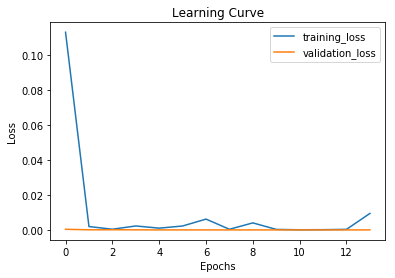

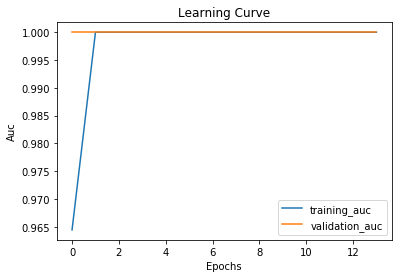

In [0]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_auc")
plt.plot(val_acc, label="validation_auc")
plt.xlabel("Epochs")
plt.ylabel("Auc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [22]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
test_gen = test_batch_generator(test_list, len(test_list))
X_batch_test= next(test_gen)

scores = model.evaluate(X_batch_test, y_test, verbose=1)
print('test loss:', scores[0])
print('test accuracy:', scores[1])

Loading trained model
99/99 [==============================] - 65s 654ms/step
test loss: 4.720299743481022e-06
test accuracy: 1.0


In [36]:
from sklearn.metrics import confusion_matrix
test_pred = model.predict(X_batch_test)
test_pred = np.argmax(test_pred, axis=1)
confusion_matrix(np.argmax(y_test, axis=1),test_pred)
pd.crosstab(np.argmax(y_test, axis=1),test_pred)

col_0,0,1,2,3,4
row_0,,,,,
0,20,0,0,0,0
1,0,20,0,0,0
2,0,0,20,0,0
3,0,0,0,19,0
4,0,0,0,0,20


In [0]:
#!pip install git+https://github.com/raghakot/keras-vis.git -U

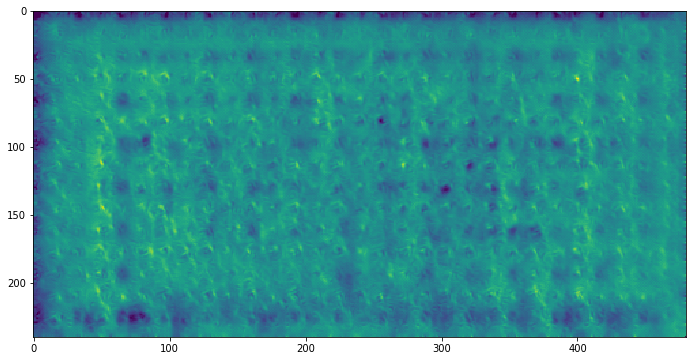

In [23]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

plt.rcParams['figure.figsize']= (18,6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx= utils.find_layer_idx(model,'dense_2')

# Swap softmax with linear
model.layers[layer_idx].activation= activations.linear
model= utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx= 0
img= visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[...,0])

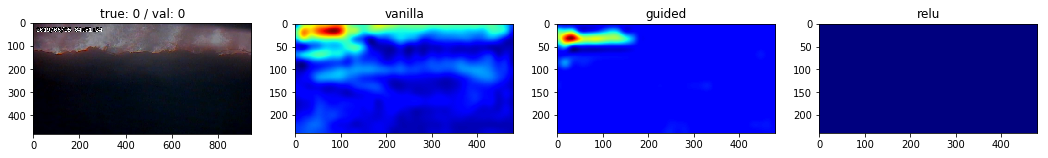

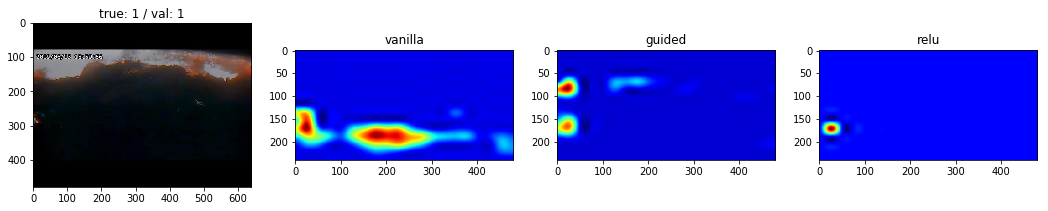

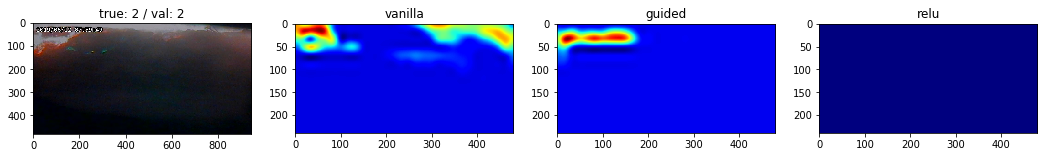

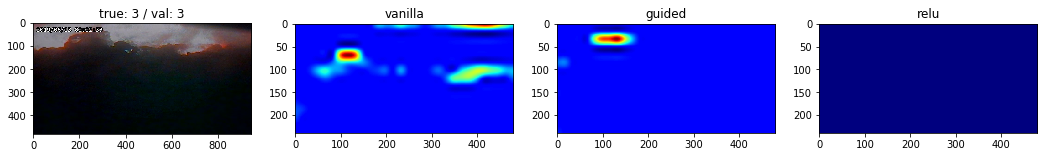

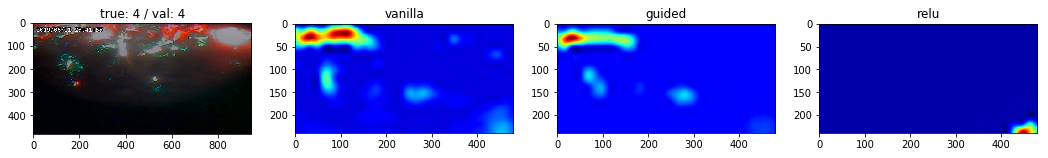

In [37]:
# feature map visualization
# https://cloud.tencent.com/developer/article/1103212
from vis.visualization import visualize_cam
layer_idx= utils.find_layer_idx(model,'dense_2')
# This corresponds to the Dense linear layer.
for class_idx in np.arange(num_class):
    try:
        indices = np.where(y_test[:, class_idx]== 1.)[0]
        idx= indices[0]
        img_v = cv2.imread(test_list[idx])[:,:,::-1].copy()
        f, ax= plt.subplots(1,4)
        ax[0].imshow(img_v)  #ax[0].imshow(img_v[...,0])
        ax[0].set_title('true: {} / val: {}'.format(class_idx,test_pred[idx]))
        for i, modifier in enumerate([None,'guided','relu']):
            grads= visualize_cam(model, layer_idx, filter_indices=class_idx,
            seed_input=img_v, backprop_modifier=modifier)
            if modifier is None:
                modifier= 'vanilla'
            ax[i+1].set_title(modifier)
            ax[i+1].imshow(grads, cmap='jet')
    except:
        print('missing {}'.format(class_idx))